In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# import os
# from hydra import initialize, initialize_config_module, initialize_config_dir, compose
# from omegaconf import OmegaConf

In [7]:
import sys
sys.path.append("/projectnb/stephenlab/jtauber/cohlib/efax")

### What did we do to generate latent data previously? let's look at that, then develop a better version with jax
- once prototype works in here, set up as part of hydra app



In [8]:
import jax.numpy as jnp
import jax.random as jr
from efax import ComplexCircularlySymmetricNormalEP, ComplexNormalEP

In [236]:
gamma = jnp.array([[5,1],[1,5]],dtype=complex) + jnp.array([[0,-1],[1,0]],dtype=complex)*1j
gamma

Array([[5.+0.j, 1.-1.j],
       [1.+1.j, 5.+0.j]], dtype=complex64)

In [237]:
eigvals, eigvecs = jnp.linalg.eigh(gamma)
A = eigvecs @ jnp.diag(jnp.sqrt(eigvals)) 

In [239]:
# confirm behaves as predicted
from_svd = eigvecs @ jnp.diag(eigvals) @ eigvecs.conj().T
jnp.all(jnp.isclose(gamma, from_svd))

Array(True, dtype=bool)

In [243]:
A.shape

(2, 2)

In [256]:
# confirm sampling via eigval decomp works
rk = jr.key(5)
L = 500000
unit_samples = jr.normal(rk, (K,L), dtype=complex)
samples = jnp.einsum('ik,kl->il', A, unit_samples)

est = jnp.einsum('il,kl->ikl', samples, samples.conj()).mean(-1)

jnp.isclose(est, gamma, atol=1e-1)

Array([[ True,  True],
       [ True,  True]], dtype=bool)

In [263]:
# confirm sampling in efax works
testccn = ComplexCircularlySymmetricNormalEP(variance=gamma)
samples = testccn.sample(rk, (L,)).swapaxes(0,1)
est = jnp.einsum('il,kl->ikl', samples, samples.conj()).mean(-1)
jnp.isclose(est, gamma, atol=1e-2)

Array([[ True,  True],
       [ True,  True]], dtype=bool)

## Great - now let's handle sampling from multiple frequencies

In [267]:
gamma1 = jnp.array([[5,1],[1,5]],dtype=complex) + jnp.array([[0,-1],[1,0]],dtype=complex)*1j
gamma = jnp.stack([gamma1, gamma1.conj()+jnp.eye(2)*5, jnp.eye(2, dtype=complex)*2])
eigvals, eigvecs = jnp.linalg.eigh(gamma)
D = jnp.apply_along_axis(jnp.diag, 1, jnp.sqrt(eigvals))
A = eigvecs @ D

test1 = eigvecs @ D
test2 = jnp.zeros_like(eigvecs, dtype=complex)
for j in range(J):
    test2 = test2.at[j,:,:].set(eigvecs[j,:,:] @ D[j,:,:])
jnp.all(test1 == test2)

Array(True, dtype=bool)

In [277]:
# confirm sampling via eigval decomp works
rk = jr.key(5)
J = gamma.shape[0]
K = gamma.shape[1]
L = 500000
unit_samples = jr.normal(rk, (J,K,L), dtype=complex)
samples = jnp.einsum('jik,jkl->jil', A, unit_samples)
est = jnp.einsum('jil,jkl->jikl', samples, samples.conj()).mean(-1)
jnp.all(jnp.isclose(est, gamma, atol=1e-1))

Array(True, dtype=bool)

In [278]:
# double confirm
est = jnp.zeros_like(gamma)
for j in range(J):
    j_samples = samples[j,:,:]
    j_est = jnp.einsum('il,kl->ikl', j_samples, j_samples.conj()).mean(-1)
    est = est.at[j,:,:].set(j_est)
jnp.all(jnp.isclose(est, gamma, atol=1e-1))

Array(True, dtype=bool)

### Now let's make a full 'z' array and embed non-zero coefficients and try to Fourier transform

In [10]:
K = 2

In [12]:
gamma1 = jnp.array([[5,1],[1,5]],dtype=complex) + jnp.array([[0,-1],[1,0]],dtype=complex)*1j
gamma_nonzero = jnp.stack([gamma1, gamma1.conj()+jnp.eye(2)*5, jnp.eye(2, dtype=complex)*2])

F = 50
gamma_full = jnp.zeros((F,K,K), dtype=complex)
nz_inds = jnp.array([5, 12, 18])
freqs = jnp.arange(1,51)
nz_filt = jnp.isin(freqs, nz_inds)
gamma_full = gamma_full.at[nz_filt,:,:].set(gamma_nonzero)

jnp.all(gamma_full[nz_filt,:,:] == gamma_nonzero)

Array(True, dtype=bool)

In [13]:
eigvals, eigvecs = jnp.linalg.eigh(gamma_full)
D = jnp.apply_along_axis(jnp.diag, 1, jnp.sqrt(eigvals))
A = eigvecs @ D

test1 = eigvecs @ D
test2 = jnp.zeros_like(eigvecs, dtype=complex)
for j in range(F):
    test2 = test2.at[j,:,:].set(eigvecs[j,:,:] @ D[j,:,:])
jnp.all(test1 == test2)

Array(True, dtype=bool)

In [16]:
rk = jr.key(5)
F = gamma_full.shape[0]
K = gamma_full.shape[1]
L = 500000
unit_samples = jr.normal(rk, (F,K,L), dtype=complex)
samples = jnp.einsum('jik,jkl->jil', A, unit_samples)
est = jnp.einsum('jil,jkl->jikl', samples, samples.conj()).mean(-1)
jnp.all(jnp.isclose(est, gamma_full, atol=1e-1))

Array(True, dtype=bool)

In [17]:
def add_dc(x, dc):
    dc_arr = jnp.array([dc])
    with_dc = jnp.concatenate([dc_arr, x])
    return with_dc

In [18]:
from functools import partial
add0 = partial(add_dc, dc=0)
zs_0dc = jnp.apply_along_axis(add0, 0, samples)


In [19]:
zs_0dc = zs_0dc.at[10:,:,:].set(0)
xs = jnp.fft.irfft(zs_0dc, axis=0)

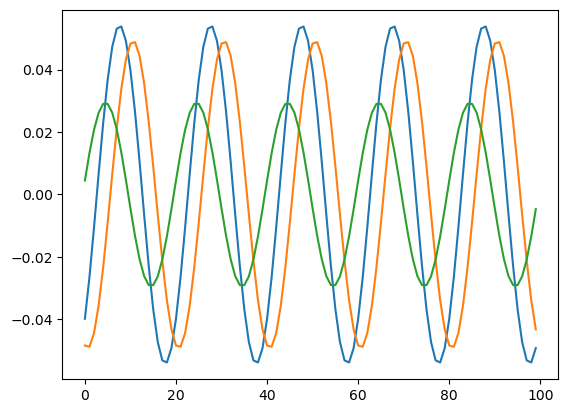

In [20]:
import matplotlib.pyplot as plt
for l in range(3):
    plt.plot(xs[:,0,l])

so... now we add gaussian noise and we have observations and just need to write out cost function and we have a model to do experiments with!

But, we'll want to set this up nicely with Hydra and separate latent state / observation generation 

In [21]:
zs_test = jnp.fft.rfft(xs, axis=0)

In [22]:
jnp.all(jnp.isclose(zs_test, zs_0dc, atol=1e-5))

Array(True, dtype=bool)

In [34]:
o1 = 1
o2 = -3 
obs_noise = o1 * 10**o2
obs = xs + jr.normal(rk, xs.shape)*jnp.sqrt(obs_noise)

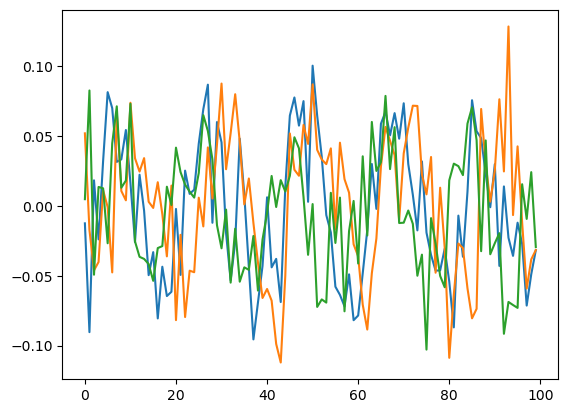

In [35]:
for l in range(3):
    plt.plot(obs[:,0,l])

In [6]:
xs = jnp.sqrt(sigma2)*jr.multivariate_normal(rk, (L,)) + jnp.array([alpha])

In [27]:
mean = jnp.array([0,0],dtype=complex)
cov = jnp.array([[5,1],[1,5]]) + jnp.array([[0,1],[1,0]])*1j

In [29]:
L = 5000
rk = jr.key(8)
# test = jr.normal(rk, (L,), dtype=complex)
test = jr.multivariate_normal(rk, mean, cov, dtype=complex)

ValueError: dtype argument to `multivariate_normal` must be a float dtype, got <class 'complex'>

In [20]:
test.real.var()

Array(0.49424648, dtype=float32)

In [7]:
# abs_config_dir=os.path.abspath("conf")
# with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
#     cfg = compose(config_name="config.yaml")
#     print(cfg)

{'db': {'driver': 'mysql', 'user': 'omry', 'password': 'secret'}}


In [1]:
# from omegaconf import DictConfig, OmegaConf
# import hydra

# @hydra.main(version_base=None, config_path="conf", config_name="config")
# def hydra_run(cfg: DictConfig) -> None:
#     print(OmegaConf.to_yaml(cfg))